<a href="https://colab.research.google.com/github/NosenkoArtem/MADMO-advanced-/blob/master/week_2/%5Bseminar%5Dweight_initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weight Initialization
На этом уроке вы узнаете, как найти хорошие начальные веса для нейронной сети. И запустить обучаться свою нейросеть. 
Инициализация веса происходит один раз, когда модель создана и до того, как она тренируется.
Имея хорошие начальные веса, можно расположить нейронную сеть близко к оптимальному решению.
Это позволяет нейронной сети быстрее прийти к наилучшему решению.


## Initial Weights and Observing Training Loss

Чтобы увидеть, как работают различные веса, мы протестируем один и тот же набор данных и нейронную сеть. Таким образом, мы знаем, что любые изменения в поведении модели происходят из-за весов, а не из-за каких-либо изменений данных или структуры модели. 


Иногда разница в потере тренировки, с течением времени, будет большой и другие времена, некоторые веса предлагают только небольшие улучшения.
### Dataset and Model

Мы обучим MLP классифицировать изображения из базы данных [Fashion-MNIST] (https://github.com/zalandoresearch/fashion-mnist) для демонстрации эффекта различных начальных Весов. Напомним, что набор данных FashionMNIST содержит изображения типов одежды; ' classes = ['футболка / топ', 'брюки', 'пуловер', 'платье', 'пальто', 'сандалии', 'рубашка', 'кроссовки', 'сумка',`ботильоны']'. Изображения нормализуются таким образом, чтобы их пиксельные значения находились в диапазоне [0.0 - 1.0).  Запустите ячейку ниже,чтобы загрузить и загрузить набор данных.



### Import Libraries and Load [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize Some Training Data

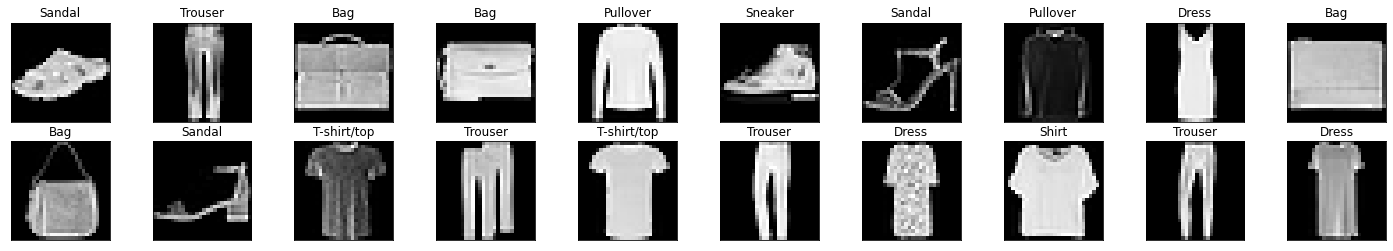

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Определите архитектуру модели

Мы определили MLP, который будем использовать для классификации набора данных.


* 3-слойный MLP со скрытыми размерами 256 и 128. 

* Этот MLP принимает в качестве входных данных сглаженное изображение (784-значный длинный вектор) и выдает 10 баллов класса в качестве выходных данных.
---
Мы проверим влияние различных начальных Весов на эту 3-слойную нейронную сеть с помощью активации ReLU и оптимизатора Adam.  

Полученные уроки применимы и к другим нейронным сетям, включая различные активации и оптимизаторы.

---

### All Zeros or Ones
Следуя принципам бритвы Оккама ([Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor)), вы могли бы естестевенно подумать, что достаточно проиницализировать все веса нулем или единицей.

При одинаковом весе все нейроны в каждом слое производят одинаковый результат.  Это затрудняет принятие решения о том, какие веса следует регулировать.

Давайте сравним потери со всеми единицами и со всеми нулевыми весами, определив две модели с этими постоянными весами.

Ниже мы используем Pytorch's [nn. init](https://pytorch.org/docs/stable/nn.html#torch-nn-init) инициализировать каждый линейный слой с постоянным весом. Библиотека init предоставляет ряд функций инициализации веса, которые дают вам возможность инициализировать веса каждого слоя в соответствии с типом слоя.

В приведенном ниже примере мы рассмотрим каждый слой / модуль в нашей модели. Если это линейный слой (как и все три слоя для этого MLP), то мы инициализируем эти веса слоев как " constant_weight` с смещением=0, используя следующий код:

>```
if isinstance(m, nn.Linear):
    nn.init.constant_(m.weight, constant_weight)
    nn.init.constant_(m.bias, 0)
```

The `constant_weight` is a value that you can pass in when you instantiate the model.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128, constant_weight=None):
        super(Net, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (hidden_2 -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(p=0.2)
        
        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    
            
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x


### Сравнение Поведения Модели

Ниже мы используем "помощников".compare_init_weights", чтобы сравнить потери обучения и проверки для двух моделей, которые мы определили выше, "model_0" и "model_1".  Эта функция принимает список моделей (каждая с различными начальными весами), имя создаваемого графика, а также загрузчики обучающих и проверочных наборов данных. Для каждой заданной модели он построит график потерь обучения для первых 100 партий и распечатает точность валидации после 2 эпох обучения. * Примечание: Если вы использовали небольшой размер пакета, вы можете увеличить количество эпох здесь, чтобы лучше сравнить, как ведут себя модели после просмотра нескольких сотен изображений.* 


Запустите ячейку ниже, чтобы увидеть разницу между весами со всеми нулями против всех единиц.

In [ ]:
# initialize two NN's with 0 and 1 constant weights
model_0 = Net(constant_weight=0)
model_1 = Net(constant_weight=1)

In [ ]:

def _get_loss_acc(model, train_loader, valid_loader,  n_epochs = 10):
    """
    Get losses and validation accuracy of example neural network
    """
    n_epochs = 2
    learning_rate = 0.001
    
    # Training loss
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    # Measurements used for graphing loss
    loss_batch = []

    for epoch in range(1, n_epochs+1):
        # initialize var to monitor training loss
        train_loss = 0.0
        ########################
        # TODO train the model #
        ########################
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record average batch loss
            loss_batch.append(loss.item()) 
             
    # after training for 2 epochs, check validation accuracy 
    correct = 0
    total = 0
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # get the predicted class from the maximum class score
        _, predicted = torch.max(output.data, 1)
        # count up total number of correct labels
        # for which the predicted and true labels are equal
        total += target.size(0)
        correct += (predicted == target).sum()
      
    # calculate the accuracy
    # to convert `correct` from a Tensor into a scalar, use .item()
    valid_acc = correct.item() / total

    # return model stats
    return loss_batch, valid_acc


In [ ]:

def compare_init_weights(
        model_list,
        plot_title,
        train_loader,
        valid_loader,
        plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['r', 'b', 'g', 'c', 'y', 'k']
    label_accs = []
    label_loss = []

    assert len(model_list) <= len(colors), 'Too many initial weights to plot'

    for i, (model, label) in enumerate(model_list):
        loss, val_acc = _get_loss_acc(model, train_loader, valid_loader)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(plot_title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 2 Epochs:')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Training Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))
        

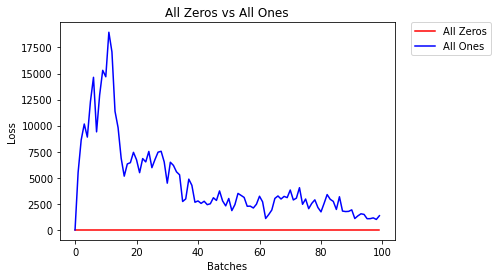

After 2 Epochs:
Validation Accuracy
    9.875% -- All Zeros
   10.250% -- All Ones
Training Loss
    2.302  -- All Zeros
  498.710  -- All Ones


In [ ]:
model_list = [(model_0, 'All Zeros'),
              (model_1, 'All Ones')]

compare_init_weights(model_list, 
                             'All Zeros vs All Ones', 
                             train_loader,
                             valid_loader)

Как вы можете видеть, точность близка к угадыванию как для нулей, так и для единиц, около 10%.

Нейронной сети трудно определить, какие веса должны быть изменены, так как нейроны имеют одинаковый выход для каждого слоя.  Чтобы избежать нейронов с одинаковым выходом, давайте использовать уникальные веса.  Мы также можем случайным образом выбрать эти веса, чтобы избежать застревания в локальном минимуме для каждого запуска.

Хорошим решением для получения этих случайных Весов является выборка из однородного распределения.

### равномерное распределение
[равномерное распределение](https://en.wikipedia.org/wiki/Uniform_distribution) имеет равную вероятность выбора любого числа из набора чисел. Мы будем выбирать из непрерывного распределения, поэтому вероятность выбора одного и того же числа невелика. 

### Uniform Initialization, Baseline


Давайте посмотрим, насколько хорошо нейронная сеть тренируется с использованием равномерной инициализации веса, где "низкий=0.0" и "высокий=1.0". Ниже я покажу вам другой способ (помимо кода класса Net) инициализации Весов сети. Чтобы определить веса вне определения модели, вы можете:
1. Определите функцию, которая присваивает веса по типу сетевого слоя

2. Применение этих весов в инициализацию модели, используя модель.apply (fn)`, который применяет функцию к каждому слою модели.

На этот раз мы будем использовать вес.данные.uniform_ ' для инициализации Весов нашей модели напрямую.

In [ ]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
      m.weight.data.uniform_(0.0, 1.0)
      m.bias.data.fill_(0.0)

In [ ]:
# create a new model with these weights
model_uniform = Net()
model_uniform.apply(weights_init_uniform)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

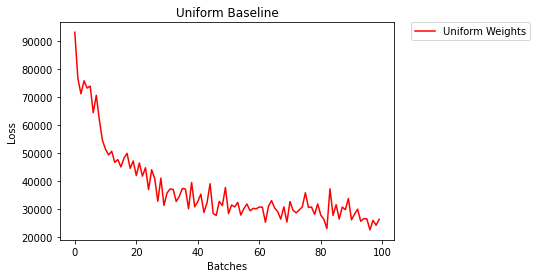

After 2 Epochs:
Validation Accuracy
   35.483% -- Uniform Weights
Training Loss
   11.628  -- Uniform Weights


In [ ]:
# evaluate behavior 
compare_init_weights([(model_uniform, 'Uniform Weights')], 
                             'Uniform Baseline', 
                             train_loader,
                             valid_loader)

---
График потерь показывает, что нейронная сеть учится, чего она не делала со всеми нулями или со всеми единицами. Мы движемся в правильном направлении!

## Общее правило установки весов
Общее правило для установки весов в нейронной сети состоит в том, чтобы установить их близкими к нулю, не будучи слишком маленькими. 
>Хорошая практика заключается в том, чтобы начать свои веса в диапазоне $[- y, y]$, где $y=1/\sqrt{n}$  
($n$ - это число входов в данный нейрон).

Давайте посмотрим, верно ли это; давайте создадим базовую линию для сравнения и центрируем наш равномерный диапазон над нулем, сдвинув его на 0,5.  Это даст нам диапазон [-0.5, 0.5].

In [ ]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
      m.weight.data.uniform_(-0.5, 0.5)
      m.bias.data.fill_(0.0)
 
# create a new model with these weights
model_centered = Net()
model_centered.apply(weights_init_uniform_center)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0.0)

# create a new model with these weights
model_rule = Net()
model_rule.apply(weights_init_uniform_rule)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

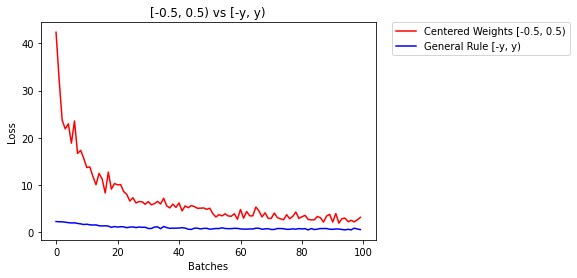

After 2 Epochs:
Validation Accuracy
   76.017% -- Centered Weights [-0.5, 0.5)
   85.858% -- General Rule [-y, y)
Training Loss
    0.587  -- Centered Weights [-0.5, 0.5)
    0.448  -- General Rule [-y, y)


In [ ]:
model_list = [(model_centered, 'Centered Weights [-0.5, 0.5)'), 
              (model_rule, 'General Rule [-y, y)')]

compare_init_weights(model_list, 
                             '[-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)

Такое поведение действительно многообещающе! Мало того, что потеря уменьшается, но, кажется, это происходит очень быстро для наших равномерных Весов, которые следуют общему правилу; всего через две эпохи мы получаем довольно высокую точность проверки, и это должно дать вам некоторое представление о том, почему начало с правильных начальных Весов действительно может помочь вашему тренировочному процессу!

---

Поскольку равномерное распределение имеет одинаковый шанс выбрать * любое значение* в диапазоне, что, если мы используем распределение, которое имеет более высокий шанс выбрать числа ближе к 0?  Давайте посмотрим на нормальное распределение.

### нормальное распределение
В отличие от равномерного распределения, [нормальное распределение](https://en.wikipedia.org/wiki/Normal_distribution) имеет более высокую вероятность выбора числа, близкого к среднему значению.

Добавьте нормальное распределение тут:
как стандартное отклонение выберите $y=1/\sqrt{n}$

In [ ]:
## complete this function
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.normal_(0, y)
      m.bias.data.fill_(0.0)
    

In [ ]:
## -- no need to change code below this line -- ##

# create a new model with the rule-based, uniform weights
model_uniform_rule = Net()
model_uniform_rule.apply(weights_init_uniform_rule)

# create a new model with the rule-based, NORMAL weights
model_normal_rule = Net()
model_normal_rule.apply(weights_init_normal)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

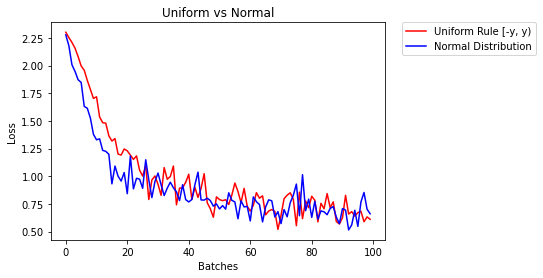

After 2 Epochs:
Validation Accuracy
   84.667% -- Uniform Rule [-y, y)
   84.708% -- Normal Distribution
Training Loss
    0.321  -- Uniform Rule [-y, y)
    0.397  -- Normal Distribution


In [ ]:
model_list = [(model_uniform_rule, 'Uniform Rule [-y, y)'), 
              (model_normal_rule, 'Normal Distribution')]

compare_init_weights(model_list, 
                             'Uniform vs Normal', 
                             train_loader,
                             valid_loader)

Нормальное распределение дает нам довольно похожее поведение по сравнению с равномерным распределением, в данном случае. Вероятно, это связано с тем, что наша сеть очень мала; более крупная нейронная сеть будет выбирать больше весовых значений из каждого из этих распределений, увеличивая эффект обоих стилей инициализации. В общем случае нормальное распределение приведет к повышению производительности модели.

In [ ]:
model_uniform_rule.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0045,  0.0276,  0.0071,  ..., -0.0103,  0.0267,  0.0218],
                      [-0.0161, -0.0479,  0.0071,  ...,  0.0172,  0.0027, -0.0295],
                      [ 0.0334,  0.0690,  0.0415,  ..., -0.0963, -0.1603, -0.0743],
                      ...,
                      [-0.0023,  0.0258, -0.0668,  ...,  0.0861,  0.0883,  0.0553],
                      [-0.0448,  0.0533,  0.0743,  ...,  0.0865,  0.0261, -0.0025],
                      [ 0.0531,  0.0392, -0.0762,  ...,  0.0195, -0.0009, -0.0492]])),
             ('fc1.bias',
              tensor([-0.0244,  0.1905,  0.0314, -0.0336, -0.0775,  0.1254,  0.1116,  0.1791,
                       0.0598,  0.0545,  0.1141,  0.1188, -0.0087, -0.0308,  0.1159,  0.1100,
                      -0.1148, -0.0758,  0.2108, -0.0973, -0.0015,  0.0559, -0.0175,  0.2097,
                      -0.0015,  0.1083,  0.0496,  0.1389,  0.1210, -0.0146,  0.1249,  0.1556,
                      -0.0071, -0.00